# SD-TSIA204 TP 2 - Linear Regression

MARCHETTI Pierre


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns

from scipy import stats
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Question 1


In [4]:
# a)
# Load the California housing dataset
data = fetch_california_housing()

X = data.data
y = data.target

# Add a column of ones to X for the bias term
X = np.c_[np.ones(X.shape[0]), X]
n, m = X.shape

# Compute the coefficients using the normal equations
coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

y_pred = X.dot(coefficients)

# Compute the MSE


def MSE(y, y_pred):
    residuals = y - y_pred
    return np.mean(residuals**2)


mse = MSE(y, y_pred)

# Compute the R2 coefficient


def R2(y, y_pred):
    residuals = y - y_pred
    return 1 - np.sum(residuals**2)/np.sum((y - np.mean(y))**2)


r2 = R2(y, y_pred)

print("MSE:", mse)
print("R2 coefficient:", r2)

# Comparing with sklearn
sklearn_mse = mean_squared_error(y, y_pred)
sklearn_r2 = r2_score(y, y_pred)

print("Sklearn MSE:", sklearn_mse)
print("Sklearn R2 coefficient:", sklearn_r2)


# b)
residuals = y - y_pred
sigma_squared = (residuals.T.dot(residuals))/(n - 2)
var = sigma_squared*np.linalg.inv(X.T.dot(X))

sigma = np.sqrt(np.diag(var))

alpha = 0.01
Q = stats.t.ppf(1 - alpha/2, df=n - 2)

low = coefficients - Q*sigma
up = coefficients + Q*sigma

for i in range(1, len(coefficients)):
    print(f"Coefficient {i}: [{low[i]}, {up[i]}]")

MSE: 0.5243209861846072
R2 coefficient: 0.606232685199805
Sklearn MSE: 0.5243209861846072
Sklearn R2 coefficient: 0.606232685199805
Coefficient 1: [0.4258838791028421, 0.44750270716241936]
Coefficient 2: [0.008286327002931075, 0.01058522906330437]
Coefficient 3: [-0.12248060459001436, -0.09216347818862117]
Coefficient 4: [0.5726004720627973, 0.7175309149682414]
Coefficient 5: [-1.6208570375363447e-05, 8.25579153219051e-06]
Coefficient 6: [-0.005041943286582654, -0.002531142023318918]
Coefficient 7: [-0.4398508467071086, -0.40277790836251015]
Coefficient 8: [-0.45391569726223985, -0.41511181210379283]


## Question 2


In [5]:
# a)
# Load the data from data.csv
data = pd.read_csv('data.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Standardize the training and testing sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# b)
# Fit a regular OLS model
model = LinearRegression()
reg = model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Question 3


In [10]:
# a)
def fit_models(X, y):

    p_min = 1
    p_values = []
    best_feature = None
    best_model = None

    for j in range(X.shape[1]):

        Xj = X[:, j].reshape(-1, 1)
        model = LinearRegression().fit(Xj, y)

        r2 = 1 - np.sum((y - model.predict(Xj))**2)/np.sum((y - np.mean(y))**2)
        f_statistic = (r2/(1 - r2))*(len(y) - 2)

        p = 1 - stats.f.cdf(f_statistic, 1, len(y) - 2)
        p_values.append(p)

        if p < p_min:
            p_min = p
            best_feature = j
            best_model = model

    return p_min, best_feature, best_model, p_values

The p-value mesures the probability of observing a test statistic as extreme as, or more extreme than, the one calculated from the data assuming that the null hypothesis is true.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


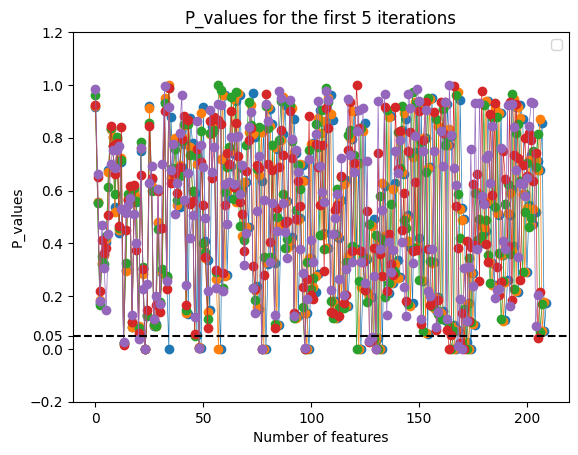

[34, 58, 123, 167, 174, 23, 133, 79, 99, 49, 20, 130]


In [18]:
# b)
def forward_variable_selection(X, y):

    n = 0
    features = list(range(X.shape[1]))
    selected_features = []
    p_values = []
    first_all_p_values = []

    while len(features) > 0:

        n += 1
        best_feature, _, min_p_value, all_p_values = fit_models(
            X[:, features], y)

        if n <= 5:
            first_all_p_values.append(all_p_values)

        if best_feature is not None and min_p_value < 0.05:
            selected_features.append(features[best_feature])
            p_values.append(min_p_value)
            features.remove(features[best_feature])
            X_best = X[:, features[best_feature]].reshape(-1, 1)
            model = LinearRegression().fit(X_best, y)
            y = y - model.predict(X_best)

        else:
            break

    return selected_features, p_values, first_all_p_values


selected_features, p_values, first_all_p_values = forward_variable_selection(
    X_train, y_train)

fig, ax = plt.subplots()
for i in range(5):
    ax.plot(first_all_p_values[i], linewidth=0.5, marker='o')

ax.axhline(y=0.05, color='black', linestyle='--')
yticks = [*ax.get_yticks(), 0.05]
yticklabels = [*ax.get_yticklabels(), 0.05]
ax.set_yticks(yticks, labels=yticklabels)

plt.xlabel('Number of features')
plt.ylabel('P_values')
plt.title('P_values for the first 5 iterations')
plt.legend()
plt.show()

print(selected_features)

## Question 4


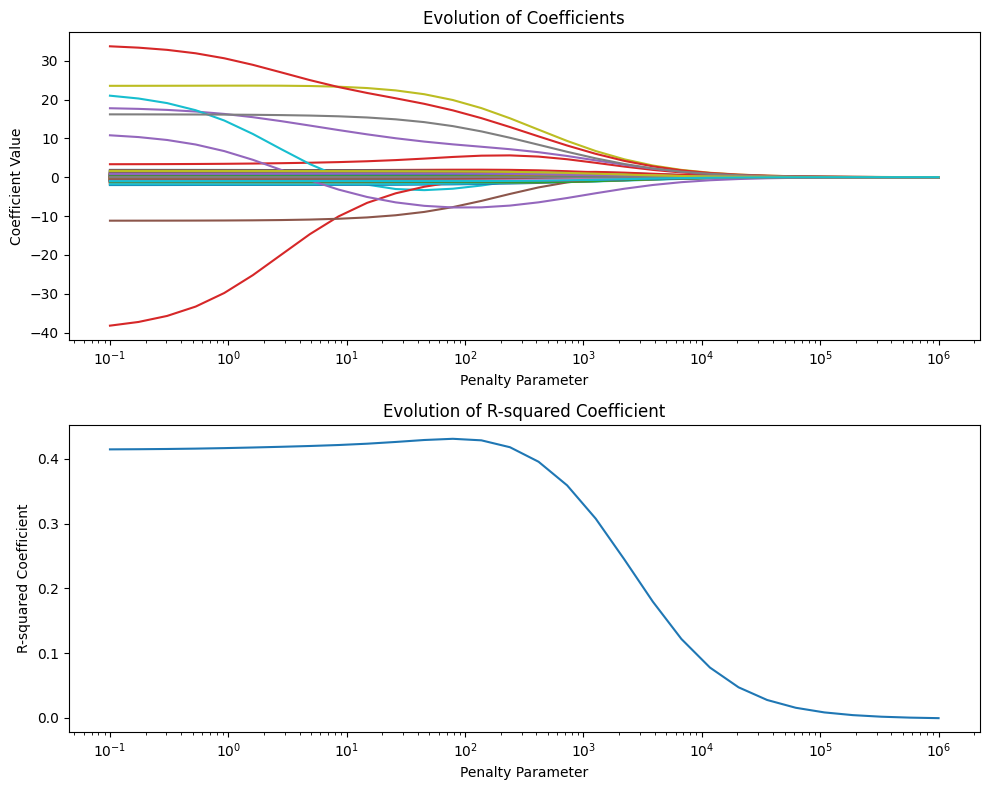

In [7]:
def regression(func, X_train, y_train, X_test, y_test, penalty_values):

    n_penalties = len(penalty_values)
    n_features = X_train.shape[1]
    coefficients = np.zeros((n_penalties, n_features))
    r2_scores = np.zeros(n_penalties)


    for i, penalty in enumerate(penalty_values):
        model = func(alpha=penalty)
        model.fit(X_train, y_train)
        coefficients[i] = model.coef_
        y_pred = model.predict(X_test)
        r2_scores[i] = r2_score(y_test, y_pred)


    fig, axes = plt.subplots(2, 1, figsize=(10, 8))


    # Plot evolution of coefficients
    for j in range(n_features):


        axes[0].plot(penalty_values, coefficients[:, j])
    axes[0].set_xlabel('Penalty Parameter')
    axes[0].set_ylabel('Coefficient Value')
    axes[0].set_xscale('log')
    axes[0].set_title('Evolution of Coefficients')


    # Plot evolution of R-squared coefficient
    axes[1].plot(penalty_values, r2_scores)
    axes[1].set_xlabel('Penalty Parameter')
    axes[1].set_ylabel('R-squared Coefficient')
    axes[1].set_xscale('log')
    axes[1].set_title('Evolution of R-squared Coefficient')


    plt.tight_layout()
    plt.show()



regression(Ridge, X_train, y_train, X_test, y_test, np.logspace(-1, 6, num=30))

## Question 5


c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.172e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-2

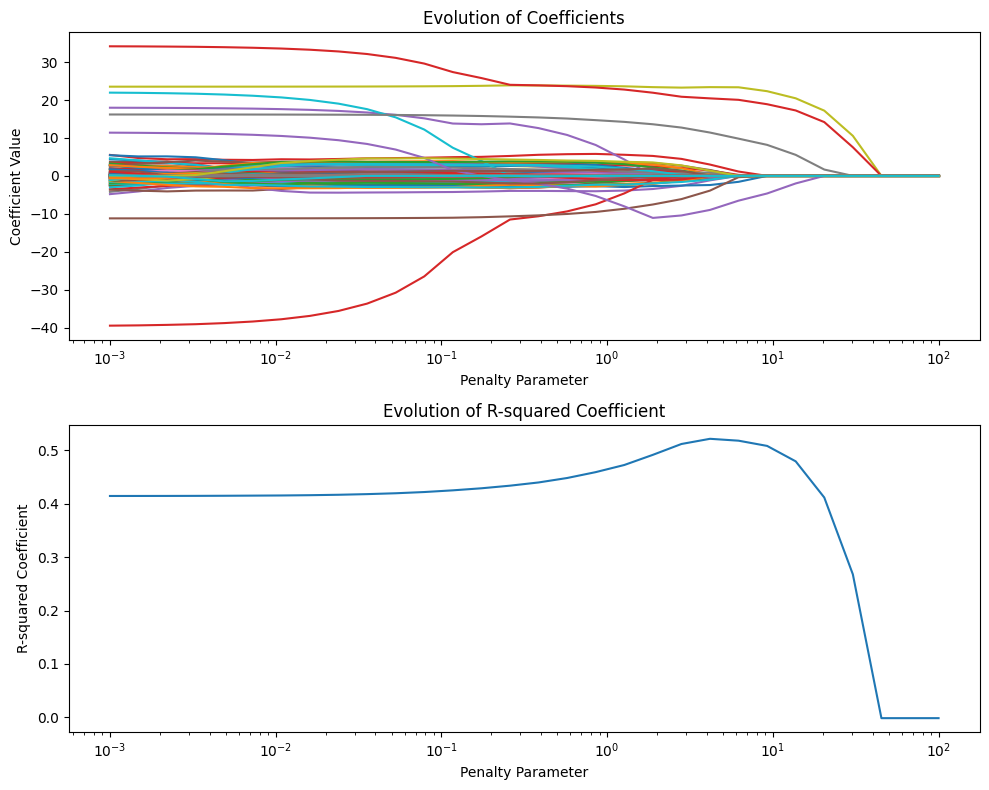

In [8]:
penalty_values = np.logspace(-3, 2, num=30)
regression(Lasso, X_train, y_train, X_test, y_test, penalty_values)

## Question 6


c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.836e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.345e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-2

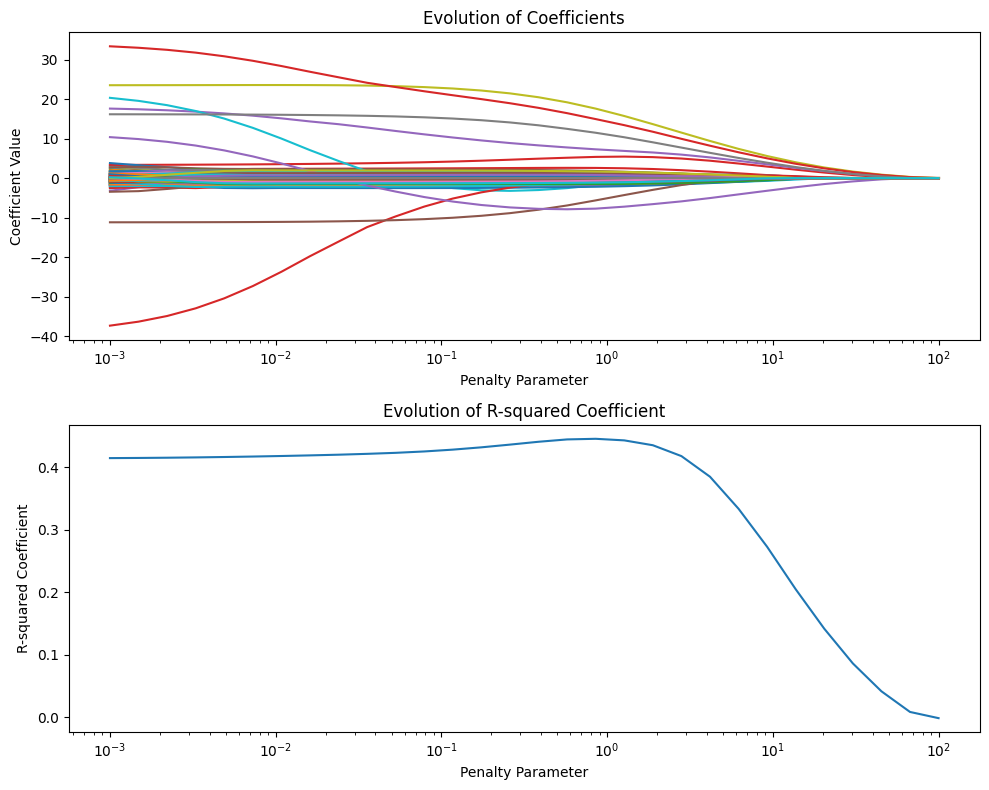

In [9]:
penalty_values = np.logspace(-3, 2, num=30)
regression(ElasticNet, X_train, y_train, X_test, y_test, penalty_values)

## Question 7


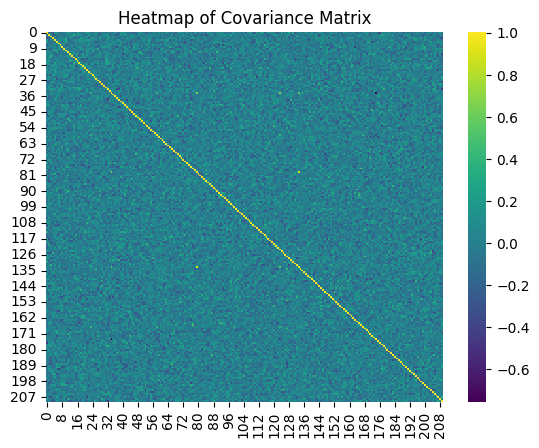

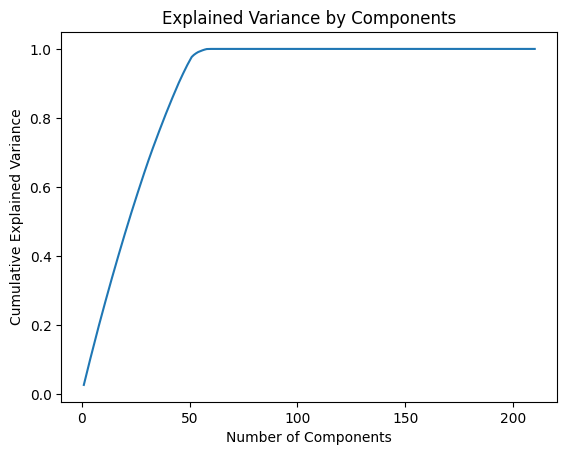

Number of components to explain more than 90 percent of the variance: 44


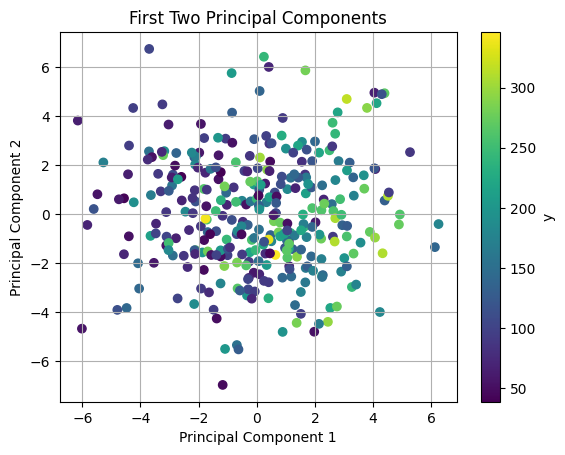

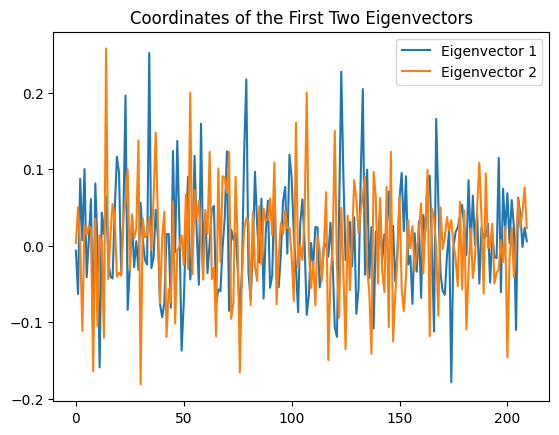

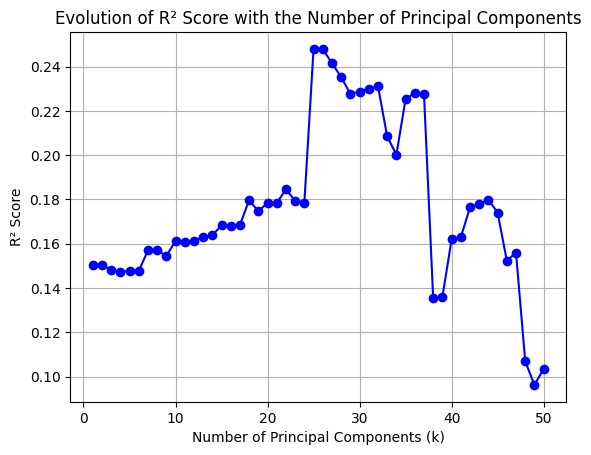

Best k: 25
Best R² score: 0.2479352565027373


In [25]:
# a)
cov_matrix = np.cov(X_train.T)

sns.heatmap(cov_matrix, cmap='viridis')
plt.title("Heatmap of Covariance Matrix")
plt.show()


# b)
# Perform Singular Value Decomposition (SVD)
U, s, V = np.linalg.svd(X_train.T @ X_train)

var_total = np.sum(s)
var_explained = np.cumsum(s) / var_total

# c)
plt.plot(range(1, len(var_explained) + 1), var_explained)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()
print('Number of components to explain more than 90 percent of the variance: ' +
      str(np.argmax(var_explained >= 0.90)))

# d)

U_train_k = U[:, :2]
X_pca_k = X_train @ U_train_k

plt.scatter(X_pca_k[:, 0], X_pca_k[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='y')
plt.title('First Two Principal Components')
plt.grid(True)
plt.show()

# e)

eigenvector_1 = U[:, 0]
eigenvector_2 = U[:, 1]
indices = np.arange(len(eigenvector_1))

plt.plot(indices, eigenvector_1, label='Eigenvector 1')
plt.plot(indices, eigenvector_2, label='Eigenvector 2')
plt.legend()
plt.title('Coordinates of the First Two Eigenvectors')
plt.show()

# f)

r2_scores = []

for k in range(1, 51):
    U_train_k = U[:, :k]
    X_train_pca_k = X_train @ U_train_k
    X_test_pca_k = X_test @ U_train_k

    model = LinearRegression().fit(X_train_pca_k, y_train)

    y_pred_test = model.predict(X_test_pca_k)
    r2_scores.append(r2_score(y_test, y_pred_test))

plt.plot(range(1, 51), r2_scores, marker='o', linestyle='-', color='b')
plt.title('Evolution of R² Score with the Number of Principal Components')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

best_k = np.argmax(r2_scores) + 1
best_score = r2_scores[best_k - 1]
print('Best k: ' + str(best_k))
print('Best R² score: ' + str(best_score))

## Question 8


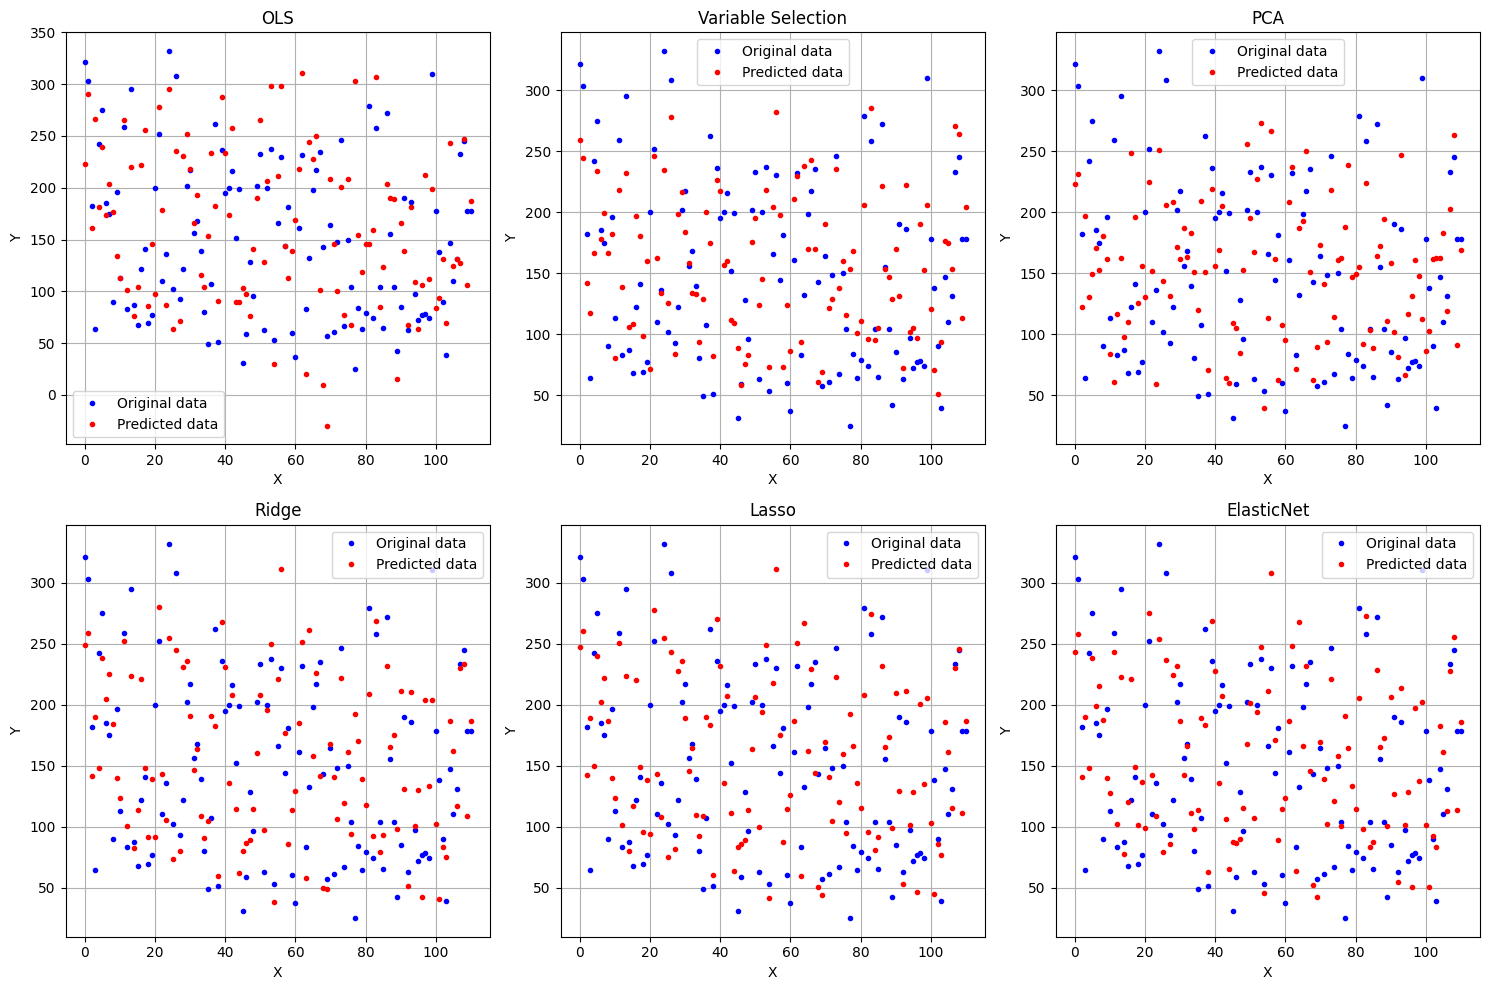

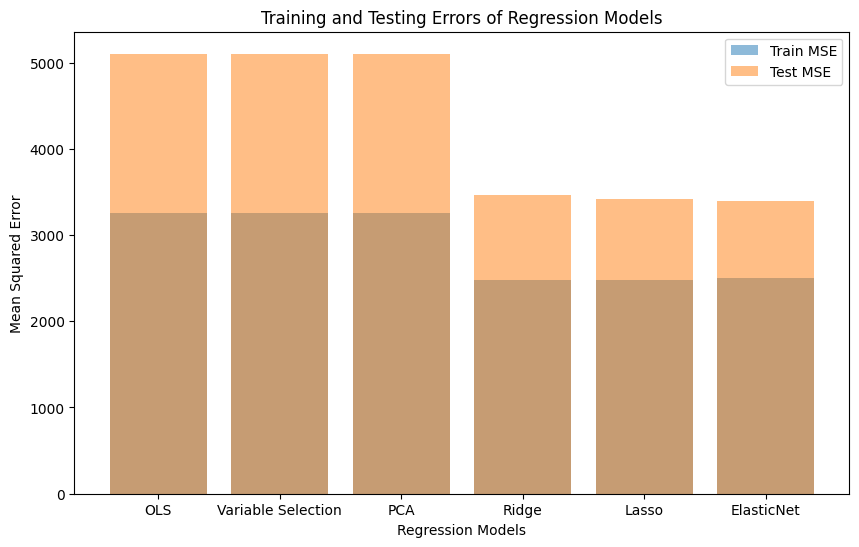

In [31]:
#Model results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

models = [
    ("OLS", LinearRegression()),
    ("Variable Selection", LinearRegression()),
    ("PCA", LinearRegression()),
    ("Ridge", Ridge(alpha=0.1)),
    ("Lasso", Lasso(alpha=0.1)),
    ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.5))
]

train_errors = {}
test_errors = {}

for i, (model_name, model) in enumerate(models, start=1):
    ax = axs.flatten()[i-1]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_errors[model_name] = mean_squared_error(y_train, y_train_pred)
    test_errors[model_name] = mean_squared_error(y_test, y_test_pred)

    if model_name == "Variable Selection":
        model.fit(X_train[:, selected_features], y_train)
        y_pred = model.predict(X_test[:, selected_features])
    elif model_name == "PCA":
        model.fit(X_train_pca_k, y_train)
        y_pred = model.predict(X_test_pca_k)
    else:
        y_pred = model.predict(X_test)

    ax.plot(y_test, 'b.', label='Original data')
    ax.plot(y_pred, 'r.', label='Predicted data')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(model_name)
    ax.legend()
    ax.grid(True)

plt.tight_layout() 
plt.show()

# Plotting training and testing errors
plt.figure(figsize=(10, 6))
plt.bar(range(len(train_errors)), list(train_errors.values()), align='center', alpha=0.5, label='Train MSE')
plt.bar(range(len(test_errors)), list(test_errors.values()), align='center', alpha=0.5, label='Test MSE')
plt.xticks(range(len(train_errors)), list(train_errors.keys()))
plt.xlabel('Regression Models')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Errors of Regression Models')
plt.legend()
plt.show()